# <font color="brown">ICA & ISOMAP </font>

<ul>
    <li>ICA remove multiple columns with min correlation with each other (use with PCA)</li>
</ul>












In [1]:
import pandas as pd
import numpy  as np
import seaborn as SB
import matplotlib.pyplot as PLT
import scipy.stats as STATS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,r2_score

In [2]:
DF = pd.read_csv('../../datasets/competitions/house-prices/train.csv')
DF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
CatCol = [
    'MSSubClass','MSZoning','Street','LotShape','LandContour',
    'LotConfig','LandSlope','Neighborhood','Condition1',
    'Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','ExterCond','ExterQual',
    'MasVnrType','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
    'Heating','HeatingQC','Electrical','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual',
    'GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','MoSold','SaleType','SaleCondition','Exterior2nd','CentralAir','OverallQual','Alley','Utilities','KitchenQual'
]
NumCol = [
    'LotFrontage','LotArea','OverallCond','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
    'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath',
    'HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
    'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
    'MiscVal','ScreenPorch','PoolArea','YearBuilt','GarageYrBlt','YearRemodAdd','YrSold'
]
DropedCols = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']

CatCol = [c for c in CatCol if c not in DropedCols]
NumCol = [c for c in NumCol if c not in DropedCols]

XCols = [*CatCol,*NumCol]
YCol = 'SalePrice'

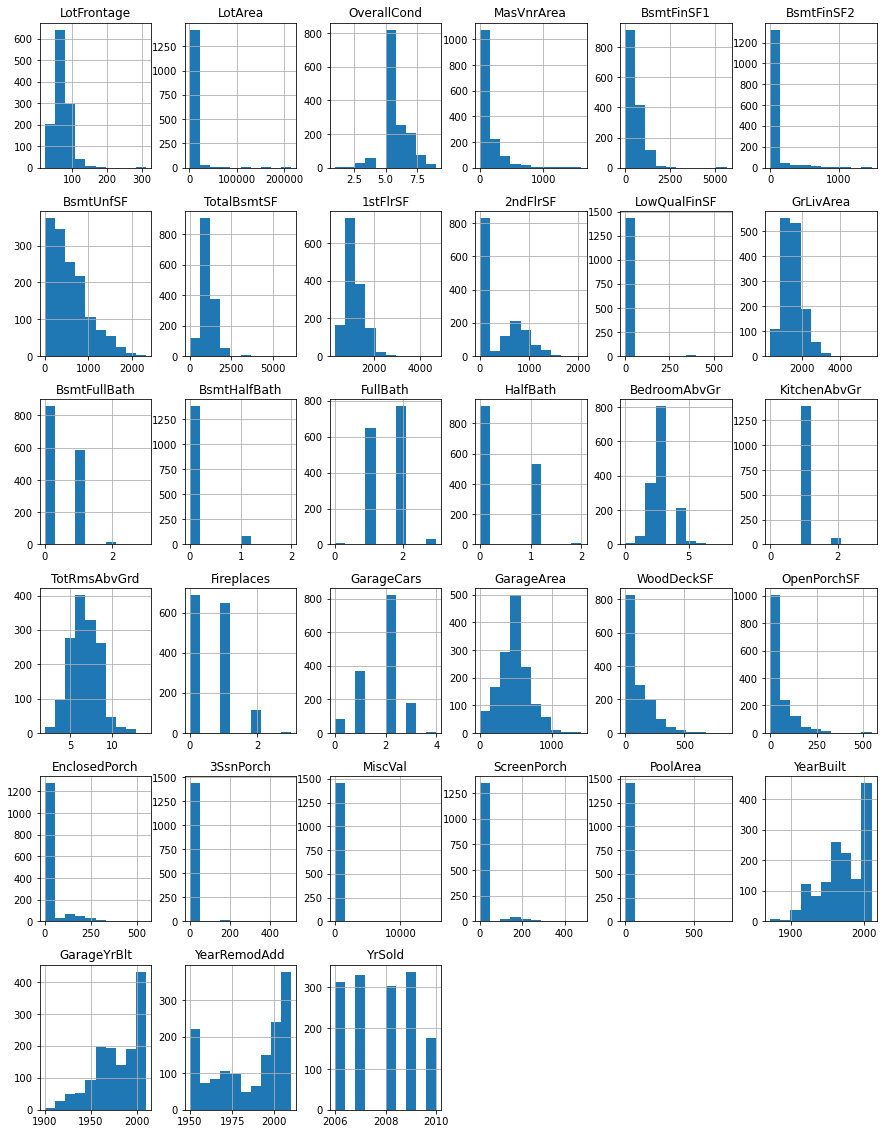

In [4]:
DF[NumCol].hist(figsize=(15,20))
PLT.show()

In [5]:
DF.drop(DropedCols,axis=1,inplace=True)
DF.drop(DF[~DF['OverallCond'].isin(range(0,11))].index,inplace=True)
DF['LotFrontage'].fillna(STATS.trim_mean(DF['LotFrontage'].dropna(),0.1),inplace=True)
DF['GarageQual'].fillna(DF['GarageQual'].mode()[0],inplace=True) 
DF['Electrical'].fillna(DF['Electrical'].mode()[0],inplace=True)
DF['BsmtFinType2'].fillna(DF['BsmtFinType2'].mode()[0],inplace=True)
DF['BsmtFinType1'].fillna(DF['BsmtFinType1'].mode()[0],inplace=True)
DF['BsmtExposure'].fillna(DF['BsmtExposure'].mode()[0],inplace=True)
DF['MasVnrArea'].fillna(STATS.trim_mean(DF['MasVnrArea'].sort_values(),0.1),inplace=True)
DF['BsmtCond'].fillna(DF['BsmtCond'].mode()[0],inplace=True)
DF['BsmtQual'].fillna(DF['BsmtQual'].mode()[0],inplace=True)
DF['GarageType'].fillna(DF['GarageType'].mode()[0],inplace=True)
DF['GarageYrBlt'].fillna(DF['GarageYrBlt'].mode()[0],inplace=True)
DF['GarageFinish'].fillna(DF['GarageFinish'].mode()[0],inplace=True)
DF['GarageCond'].fillna(DF['GarageCond'].mode()[0],inplace=True)
DF['MasVnrType'].fillna(DF['MasVnrType'].mode()[0],inplace=True)

In [6]:
def OHC_transformer_single_column(DF,columns):
    
    for column_name in columns:
        label_encoder = LabelEncoder()
        encoded = label_encoder.fit_transform(DF[column_name])
        labels =pd.Series(label_encoder.classes_)

        clmt = ColumnTransformer([(column_name,OneHotEncoder(),[0])], remainder='passthrough')
        clmt_fited_data = clmt.fit_transform(DF[[column_name]]) 
        clmt_fited_data = clmt_fited_data if type(clmt_fited_data)== np.ndarray else clmt_fited_data.toarray()  
        NDF = pd.DataFrame(clmt_fited_data,columns=[f'{column_name}_{x}' for x in labels])
        
        merged = DF.merge(NDF, left_index=True,right_index=True)
        merged = merged.drop(columns=[column_name])
        DF = merged
    return DF

In [7]:
DF = OHC_transformer_single_column(DF,CatCol)

In [8]:
X = DF[DF.columns.difference(['id','SalePrice'])]
Y = DF['SalePrice']
minmaxSCL = MinMaxScaler(feature_range=(0,1))
X  = minmaxSCL.fit_transform(X)

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=3020,test_size=.25)

In [10]:
random_forest_gtboost = GradientBoostingRegressor(
    random_state=3020,
    n_estimators=500,
    max_leaf_nodes=10,
    subsample=.9
)
random_forest_gtboost.fit(X_train,Y_train)
random_forest_gtboost.score(X_test,Y_test)

0.9074683847188404

In [11]:
Y_predicted_gtboost = random_forest_gtboost.predict(X_test)
mean_absolute_error(Y_test,Y_predicted_gtboost)

14719.906749169955

## <font color="green" >ICA & ISOMAP   :</font>

In [36]:
from sklearn.decomposition import FastICA
from sklearn.datasets import make_moons
from sklearn.manifold import Isomap

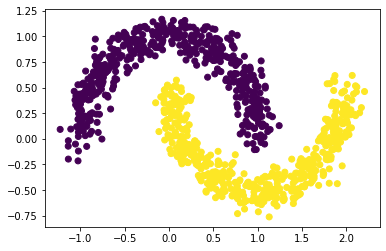

In [98]:
XM,YM = make_moons(n_samples=1000, noise=0.1)
PLT.scatter(XM[:,0],XM[:,1],c=YM)

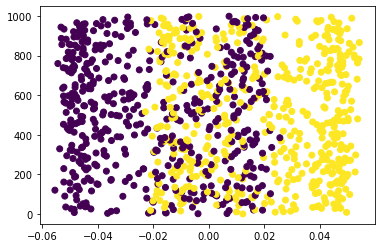

In [99]:
ica = FastICA(n_components=1)
XICA = ica.fit_transform(XM)
PLT.scatter(XICA[:,0],range(0,len(XICA)),c=YM)

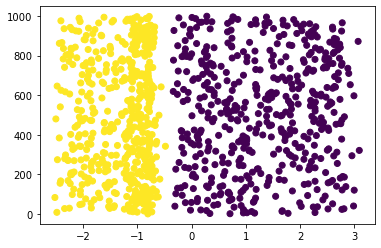

In [100]:
isomap = Isomap(n_components=1,n_neighbors=7)
XISO = isomap.fit_transform(XM)
PLT.scatter(XISO[:,0],range(0,len(XISO)),c=YM)

In [105]:
X_train,X_test,Y_train,Y_test = train_test_split(XISO,YM,random_state=3020,test_size=.25)

In [106]:
random_forest_gtboost = GradientBoostingRegressor(
    random_state=3020,
    n_estimators=500,
    max_leaf_nodes=10,
    subsample=.9
)
random_forest_gtboost.fit(X_train,Y_train)
random_forest_gtboost.score(X_test,Y_test)

0.9999999999999992